In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import seaborn as sns
import math
from scipy.stats import ks_2samp
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings("ignore")
matplotlib.rcParams.update({'font.size': 24})

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid = False)

random_state = 42

In [66]:
airbnbs = pd.read_csv("./airbnbs_to_compare.csv")

In [67]:
airbnbs.columns

Index(['Unnamed: 0', 'accommodates', 'amenities', 'availability_30',
       'bathrooms', 'bed_type', 'bedrooms', 'beds', 'cancellation_policy',
       'city', 'has_availability', 'host_id', 'id', 'instant_bookable',
       'latitude', 'longitude', 'metropolitan', 'name', 'price',
       'property_type', 'review_scores_checkin', 'review_scores_cleanliness',
       'review_scores_communication', 'review_scores_location',
       'review_scores_rating', 'review_scores_value', 'room_type', 'state',
       'weekly_price', 'zipcode', 'overall_activity', 'clean_zipcodes'],
      dtype='object')

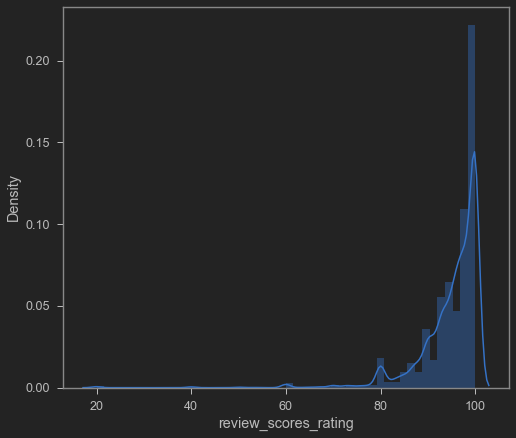

In [68]:
sns.distplot(airbnbs['review_scores_rating'])

In [72]:
#airbnbs = airbnbs.dropna(subset = ['review_scores_rating'])
airbnbs['id']

0          665257
1         2746729
2         6919450
3        12286328
4          156926
           ...   
32362    18162696
32363    18506757
32364    18192212
32365    17339165
32366    17383627
Name: id, Length: 32367, dtype: int64

In [10]:
airbnbs['cancellation_policy'].unique()# = airbnbs['cancellation_policy']

array(['moderate', 'strict', 'flexible', 'super_strict_30',
       'super_strict_60', 'no_refunds'], dtype=object)

In [11]:
d = {'flexible':1, 'moderate':2, 'strict':3, 'super_strict_30':4, 'super_strict_60':5,'no_refunds':6}

In [12]:
airbnbs['cancellation_policy'] = airbnbs['cancellation_policy'].apply(lambda row: d[row])

In [13]:
airbnbs

,Unnamed: 0,accommodates,amenities,availability_30,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,...,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,room_type,state,weekly_price,zipcode,overall_activity,clean_zipcodes
0,0,2.0,"{""Wireless Internet"",""Air Conditioning"",Kitche...",0,1.0,Real Bed,1.0,1.0,2,Asheville,...,10.0,9.0,96.0,10.0,Entire home/apt,NC,$650.00,28806.0,0.0,28806.0
1,1,4.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",17,1.0,Real Bed,1.0,2.0,3,Asheville,...,10.0,9.0,96.0,9.0,Entire home/apt,NC,NaN,28806.0,68.0,28806.0
4,4,6.0,"{Internet,""Wireless Internet"",""Free Parking on...",25,2.5,Real Bed,1.0,6.0,2,Asheville,...,9.0,9.0,93.0,10.0,Shared room,NC,NaN,28806.0,150.0,28806.0
5,5,10.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",17,2.5,Real Bed,4.0,5.0,3,Asheville,...,9.0,8.0,78.0,8.0,Entire home/apt,NC,"$1,550.00",28806.0,170.0,28806.0
6,6,2.0,"{Internet,""Wireless Internet"",""Air Conditionin...",16,1.0,Real Bed,1.0,1.0,1,Asheville,...,10.0,9.0,93.0,9.0,Private room,NC,$400.00,28806.0,32.0,28806.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32357,50038,2.0,"{TV,Internet,""Wireless Internet"",Pool,Kitchen,...",26,1.0,Real Bed,1.0,1.0,2,los angeles,...,10.0,10.0,98.0,10.0,Private room,CA,$525.00,90004,52.0,90004.0
32358,50039,8.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",0,3.0,Real Bed,4.0,4.0,3,los angeles,...,10.0,10.0,100.0,8.0,Entire home/apt,CA,"$10,000.00",90004,0.0,90004.0
32359,50041,5.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",29,2.5,Real Bed,3.0,4.0,3,los angeles,...,10.0,10.0,97.0,9.0,Entire home/apt,CA,NaN,90004,145.0,90004.0
32360,50042,2.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1,1.0,Real Bed,1.0,1.0,2,los angeles,...,10.0,10.0,95.0,10.0,Entire home/apt,CA,NaN,90004,2.0,90004.0


In [31]:
venues_w_zip = pd.read_csv("./venues_w_zip.csv")

In [32]:
venues_w_zip

,Unnamed: 0,city,id,latitude,longitude,name,rating,types,zipcodes
0,0,asheville,8736e812595db852ccab223019a477b918b64d4d,35.442805,-82.264081,The Esmeralda Inn & Restaurant,4.4,"['lodging', 'restaurant', 'food', 'point_of_in...",28720
1,1,asheville,479c99c6cc5aa91a6161fecc48bd24258a74bd58,35.564035,-82.278943,Straightaway Cafe,4.5,"['restaurant', 'food', 'point_of_interest', 'e...",28711
2,2,asheville,3e41ce673ee203416cb6f44894e49b2ee93347b1,35.564140,-82.278953,straightaway cafe,NaN,"['restaurant', 'food', 'point_of_interest', 'e...",28711
3,3,asheville,ce0b0e6fc251f546370fed20d39778ea796e5475,35.646791,-82.299074,The Huckleberry Cafe,5.0,"['restaurant', 'food', 'point_of_interest', 'e...",28757
4,4,asheville,f60446561634f4d44e6563dcf17f2b65eb4096f2,35.752135,-82.273258,Mount Mitchell State Park- Restaurant,4.0,"['restaurant', 'food', 'point_of_interest', 'e...",28714
...,...,...,...,...,...,...,...,...,...
121002,121002,los angeles,011132e6cc3e3a0040e89b9ac1b91804ad57b544,34.149800,-118.400532,Henry Films Inc,5.0,"['amusement_park', 'point_of_interest', 'estab...",91604
121003,121003,los angeles,824cbcf1d371e1594220b32bfd905c3f21bec09f,34.154163,-118.415763,Boney Island,4.8,"['amusement_park', 'point_of_interest', 'estab...",91604
121004,121004,los angeles,46106265190691f9e91e1cd0bc95dab12cd2dffd,34.008576,-118.498101,Pacific Park,4.5,"['amusement_park', 'point_of_interest', 'estab...",90401
121005,121005,los angeles,53a98917cb8f751b1ccfa16d06b4003168431bb4,34.211193,-118.492984,Sky Zone Trampoline Park,4.3,"['amusement_park', 'point_of_interest', 'estab...",91406


In [37]:
places = {}

for zipcode in airbnbs['clean_zipcodes'].unique():
    places[zipcode] = 0

In [45]:
def clean(zipcode):
    # str to int
    if zipcode != zipcode:
        return np.nan
    elif  len(zipcode.split('.')) > 1:
        return int(zipcode.split('.')[0])
    elif len(zipcode.split('-')) > 1:
        return int(zipcode.split('-')[0])
    elif len(zipcode.split(':')) > 1:
        return int(zipcode.split(':')[0])
    elif len(zipcode.split(' ')) > 1:
        if len(zipcode.split(' ')) == 2:
            return int(zipcode.split(' ')[1])
        else:
            return int(zipcode.split(' ')[0])
        
    elif len(zipcode.split('\n')) > 1:
        return int(zipcode.split('\n')[0])
    else:
        return int(zipcode)

In [46]:
for index in venues_w_zip.index:
    if clean(venues_w_zip.loc[index]['zipcodes']) in places.keys():
        places[clean(venues_w_zip.loc[index]['zipcodes'])] += 1

In [47]:
places

{28806.0: 915,
 28801.0: 1152,
 78751.0: 364,
 78705.0: 477,
 78722.0: 231,
 78745.0: 561,
 78704.0: 722,
 78741.0: 537,
 78746.0: 273,
 78702.0: 884,
 78703.0: 265,
 78701.0: 966,
 78723.0: 470,
 37209.0: 639,
 37206.0: 582,
 37212.0: 528,
 37203.0: 1095,
 37216.0: 324,
 70115.0: 575,
 70130.0: 903,
 70112.0: 261,
 70117.0: 1128,
 70118.0: 1334,
 70119.0: 1057,
 70116.0: 659,
 90018.0: 294,
 90019.0: 329,
 90004.0: 302,
 90006.0: 478,
 90005.0: 291,
 90039.0: 304,
 90292.0: 628,
 90035.0: 598,
 90034.0: 935,
 90049.0: 319,
 90036.0: 502,
 90048.0: 1065,
 90069.0: 1298,
 90046.0: 660,
 90210.0: 994,
 91604.0: 850,
 91601.0: 646,
 90404.0: 548,
 90403.0: 203,
 90025.0: 1046,
 90064.0: 1561,
 90012.0: 669,
 90066.0: 775,
 90291.0: 1034,
 90065.0: 263,
 90017.0: 259,
 90028.0: 938,
 90038.0: 263,
 90068.0: 130,
 90029.0: 477,
 90027.0: 422,
 90042.0: 540,
 90026.0: 460,
 91748.0: 0,
 90405.0: 629,
 90803.0: 0,
 90802.0: 0,
 90265.0: 0,
 90024.0: 592}

In [59]:
df_high = pd.read_csv("./df_high.csv")
df_high['no_of_venues'] = df_high['zipcode'].apply(lambda z: places[z])
df_high

,Unnamed: 0,zipcode,state,number_of_listings,overall_capacity,overall_availability,children,young_adults,low_income,medium_income,median_household_income,households,no_of_venues
0,0,28806,NC,239,821.0,3412,0.190200,0.340500,16.8,27.0,41208.0,16570,915
1,1,28801,NC,203,660.0,2590,0.132028,0.317692,25.1,19.0,31359.0,6511,1152
2,12,78751,TX,426,1487.0,4390,0.092999,0.465826,16.4,24.8,45726.0,7388,364
3,14,78705,TX,509,1922.0,4293,0.017622,0.153960,54.8,12.3,12385.0,8704,477
4,16,78722,TX,205,822.0,2335,0.123751,0.481159,7.1,33.1,64929.0,2973,231
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,331,91748,CA,355,1202.0,7183,0.143221,0.276984,9.8,31.2,58502.0,13476,0
60,353,90405,CA,299,973.0,3499,0.119972,0.337921,14.5,24.7,77948.0,14254,629
61,355,90803,CA,224,864.0,2941,0.094579,0.351698,6.5,31.6,75197.0,16995,0
62,356,90802,CA,312,931.0,4618,0.136075,0.392364,18.9,27.2,42829.0,20636,0


In [60]:
df_high['number_of_listings'].corr(df_high['no_of_venues'])

0.21997714574672983

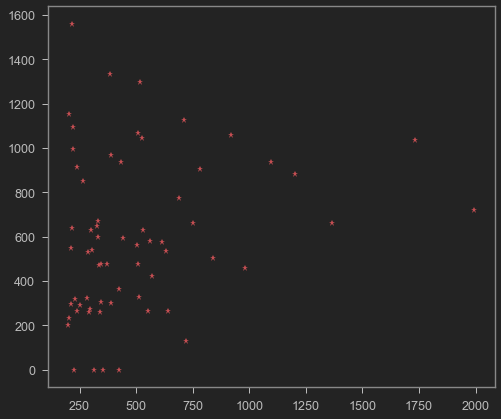

In [63]:
plt.plot(df_high['number_of_listings'], df_high['no_of_venues'], 'r*')

In [50]:
airbnbs['no_of_venues'] = airbnbs['clean_zipcodes'].apply(lambda zipcode: places[zipcode])

In [53]:
airbnbs.columns

Index(['Unnamed: 0', 'accommodates', 'amenities', 'availability_30',
       'bathrooms', 'bed_type', 'bedrooms', 'beds', 'cancellation_policy',
       'city', 'has_availability', 'host_id', 'id', 'instant_bookable',
       'latitude', 'longitude', 'metropolitan', 'name', 'price',
       'property_type', 'review_scores_checkin', 'review_scores_cleanliness',
       'review_scores_communication', 'review_scores_location',
       'review_scores_rating', 'review_scores_value', 'room_type', 'state',
       'weekly_price', 'zipcode', 'overall_activity', 'clean_zipcodes',
       'no_of_venues'],
      dtype='object')

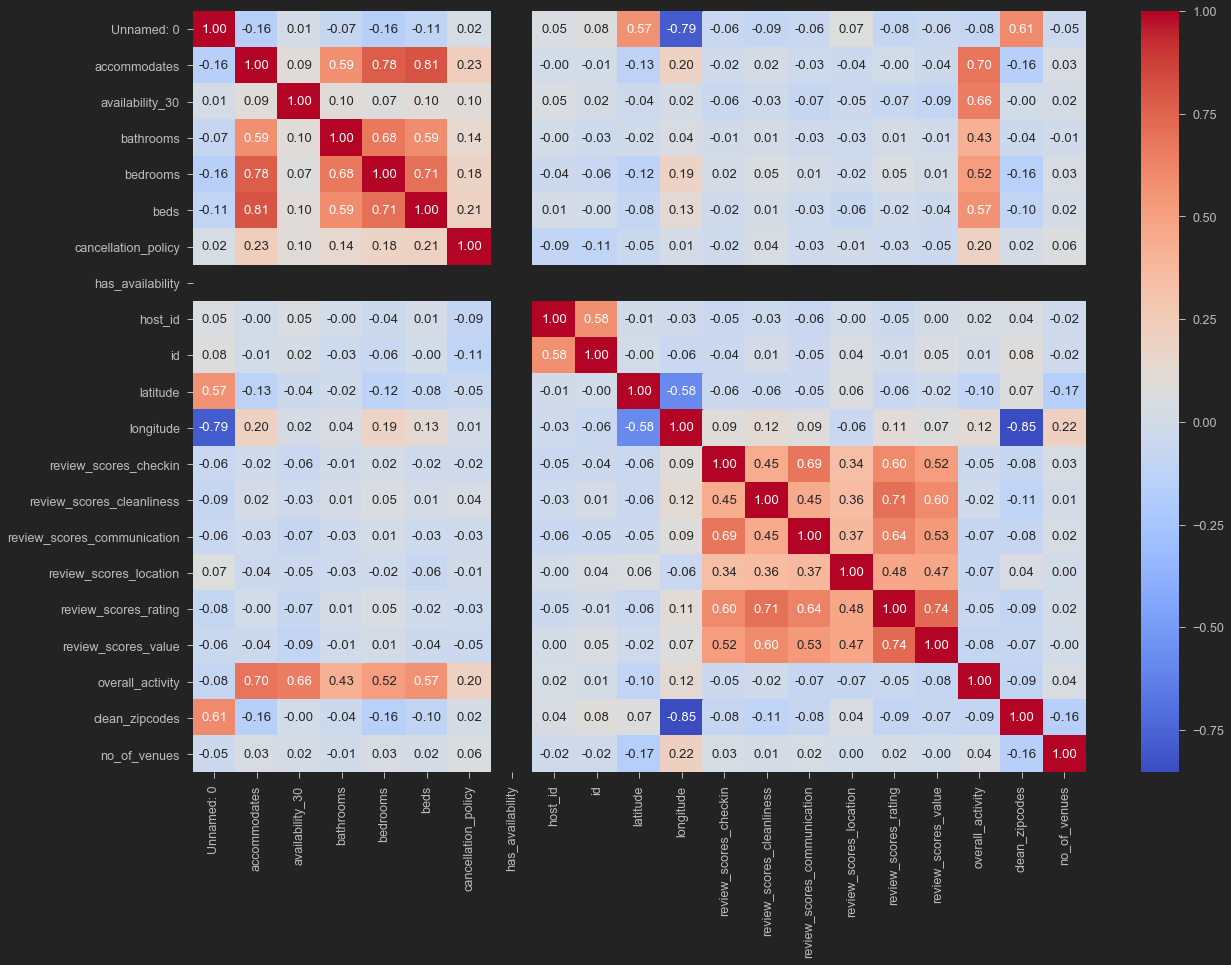

In [54]:
correlation = airbnbs.corr()

plt.figure(figsize = (20, 14))

sns.heatmap(correlation,annot=True, fmt = ".2f", cmap = "coolwarm")

In [55]:
places

{28806.0: 915,
 28801.0: 1152,
 78751.0: 364,
 78705.0: 477,
 78722.0: 231,
 78745.0: 561,
 78704.0: 722,
 78741.0: 537,
 78746.0: 273,
 78702.0: 884,
 78703.0: 265,
 78701.0: 966,
 78723.0: 470,
 37209.0: 639,
 37206.0: 582,
 37212.0: 528,
 37203.0: 1095,
 37216.0: 324,
 70115.0: 575,
 70130.0: 903,
 70112.0: 261,
 70117.0: 1128,
 70118.0: 1334,
 70119.0: 1057,
 70116.0: 659,
 90018.0: 294,
 90019.0: 329,
 90004.0: 302,
 90006.0: 478,
 90005.0: 291,
 90039.0: 304,
 90292.0: 628,
 90035.0: 598,
 90034.0: 935,
 90049.0: 319,
 90036.0: 502,
 90048.0: 1065,
 90069.0: 1298,
 90046.0: 660,
 90210.0: 994,
 91604.0: 850,
 91601.0: 646,
 90404.0: 548,
 90403.0: 203,
 90025.0: 1046,
 90064.0: 1561,
 90012.0: 669,
 90066.0: 775,
 90291.0: 1034,
 90065.0: 263,
 90017.0: 259,
 90028.0: 938,
 90038.0: 263,
 90068.0: 130,
 90029.0: 477,
 90027.0: 422,
 90042.0: 540,
 90026.0: 460,
 91748.0: 0,
 90405.0: 629,
 90803.0: 0,
 90802.0: 0,
 90265.0: 0,
 90024.0: 592}